In [1]:
from model import Deeplabv3
import pickle
import numpy as np
import keras
import matplotlib 
import matplotlib.image as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
import PIL
import tqdm
import cv2
from utils import *
import tqdm

H:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
H:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '

In [2]:
check_point_file = "./deeplabv3_oneGPU_model_256_256_new.h5"
model_checkpoint = ModelCheckpoint(check_point_file, monitor="val_loss", save_best_only=True,
                          save_weights_only=False, verbose=1)
callbacks=[model_checkpoint]
model = Deeplabv3(input_shape=(256,256,3), classes=2)
#model = keras.utils.multi_gpu_model(model,gpus=2)
#model = get_model(input_shape=(512,512,3))
model.load_weights(check_point_file)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
import numpy as np
import cv2


def compute(img, min_percentile, max_percentile):
    """计算分位点，目的是去掉图1的直方图两头的异常情况"""
    max_percentile_pixel = np.percentile(img, max_percentile)
    min_percentile_pixel = np.percentile(img, min_percentile)

    return max_percentile_pixel, min_percentile_pixel


def aug(src):
    """图像亮度增强"""
    if get_lightness(src)>170:
        print("图片亮度足够，不做增强")
    # 先计算分位点，去掉像素值中少数异常值，这个分位点可以自己配置。
    # 比如1中直方图的红色在0到255上都有值，但是实际上像素值主要在0到20内。
    max_percentile_pixel, min_percentile_pixel = compute(src, 5, 95)
    
    # 去掉分位值区间之外的值
    src[src>=max_percentile_pixel] = max_percentile_pixel
    src[src<=min_percentile_pixel] = min_percentile_pixel

    # 将分位值区间拉伸到0到255，这里取了255*0.1与255*0.9是因为可能会出现像素值溢出的情况，所以最好不要设置为0到255。
    out = np.zeros(src.shape, src.dtype)
    cv2.normalize(src, out, 0,255,cv2.NORM_MINMAX)

    return out

def get_lightness(src):
    # 计算亮度
    hsv_image = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
    lightness = hsv_image[:,:,2].mean()
    
    return  lightness


In [4]:
# img = aug(img)

In [5]:
files = glob.glob("../1-40/*.jpg")

In [6]:
for file in files:
    print("Processing file: %s" % file)
    raw_img = np.array(PIL.Image.open(file).convert('RGB'))
    size = 256
    row = np.floor(raw_img.shape[0]/size)
    colmn = np.floor(raw_img.shape[1]/size)
    for i in range(3):
        raw_img[:,:,i] = (raw_img[:,:,i] - np.mean(raw_img[:,:,i]))/(np.std(raw_img[:,:,i]))
    pred_result = np.empty(raw_img.shape[:2])
    crf_result = np.empty(raw_img.shape[:2])
    img_crf_full = np.array(PIL.Image.open(file).convert('RGB'))
    for i in tqdm.tqdm(range(int(row-1))):
        row_begin = i*size
        if i == row-1:
            row_end = pred_result.shape[0]
        else:
            row_end = i*size+size
        for j in range(int(colmn-1)):
            colmn_begin = j*size
            if j == colmn-1:
                colmn_end = pred_result.shape[1]
            else:
                colmn_end = j*size+size
            img = raw_img[row_begin:row_end, colmn_begin:colmn_end]
    #         img_crf = img_crf_full[row_begin:row_end, colmn_begin:colmn_end]
            img_shape = img.shape[:2]
            pred = model.predict(np.expand_dims(cv2.resize(img,(size,size)), axis=0))
            pred = np.argmax(pred, axis=-1)[0]
            pred = pred.reshape(img_shape)
    #         pred_crf = do_crf(img_crf, pred, zero_unsure=False)
            pred_result[row_begin:row_end, colmn_begin:colmn_end] = pred
    #         crf_result[row_begin:row_end, colmn_begin:colmn_end] = pred_crf
    result_file = "result" + os.path.split(file)[-1]
    PIL.Image.fromarray((pred_result*255).astype("uint8")).save("../1-40result/"+result_file)

Processing file: ../1-40\1.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:58<00:00,  1.10s/it]


Processing file: ../1-40\10.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.59it/s]


Processing file: ../1-40\100.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:49<00:00,  1.02s/it]


Processing file: ../1-40\11.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.03it/s]


Processing file: ../1-40\12.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.28it/s]


Processing file: ../1-40\13.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.34it/s]


Processing file: ../1-40\14.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.32it/s]


Processing file: ../1-40\15.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.35it/s]


Processing file: ../1-40\16.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.36it/s]


Processing file: ../1-40\17.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.19it/s]


Processing file: ../1-40\18.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.02it/s]


Processing file: ../1-40\19.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.20it/s]


Processing file: ../1-40\2.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.27it/s]


Processing file: ../1-40\25.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:54<00:00,  1.02s/it]


Processing file: ../1-40\3.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.66it/s]


Processing file: ../1-40\37.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:54<00:00,  1.02s/it]


Processing file: ../1-40\4.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.53it/s]


Processing file: ../1-40\5.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.31it/s]


Processing file: ../1-40\59.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


Processing file: ../1-40\6.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.88it/s]


Processing file: ../1-40\7.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.32it/s]


Processing file: ../1-40\74.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.06it/s]


Processing file: ../1-40\8.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.01it/s]


Processing file: ../1-40\9.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.28it/s]


In [7]:
os.path.split("../1-50/1.jpg")

('../1-50', '1.jpg')

In [13]:
PIL.Image.fromarray((pred_result*255).astype("uint8")).save("./result.png")

NameError: name 'pred_result' is not defined

In [14]:
for i in tqdm.tqdm(range(int(row-1))):
    row_begin = i*size
    if i == row-1:
        row_end = pred_result.shape[0]
    else:
        row_end = i*size+size
    for j in range(int(colmn-1)):
        colmn_begin = j*size
        if j == colmn-1:
            colmn_end = pred_result.shape[1]
        else:
            colmn_end = j*size+size
        img = raw_img[row_begin:row_end, colmn_begin:colmn_end]
#         img_crf = img_crf_full[row_begin:row_end, colmn_begin:colmn_end]
        img_shape = img.shape[:2]
        pred = model.predict(np.expand_dims(cv2.resize(img,(size,size)), axis=0))
        pred = np.argmax(pred, axis=-1)[0]
        pred = pred.reshape(img_shape)
#         pred_crf = do_crf(img_crf, pred, zero_unsure=False)
        pred_result[row_begin:row_end, colmn_begin:colmn_end] = pred
#         crf_result[row_begin:row_end, colmn_begin:colmn_end] = pred_crf

NameError: name 'row' is not defined

In [10]:
%matplotlib inline

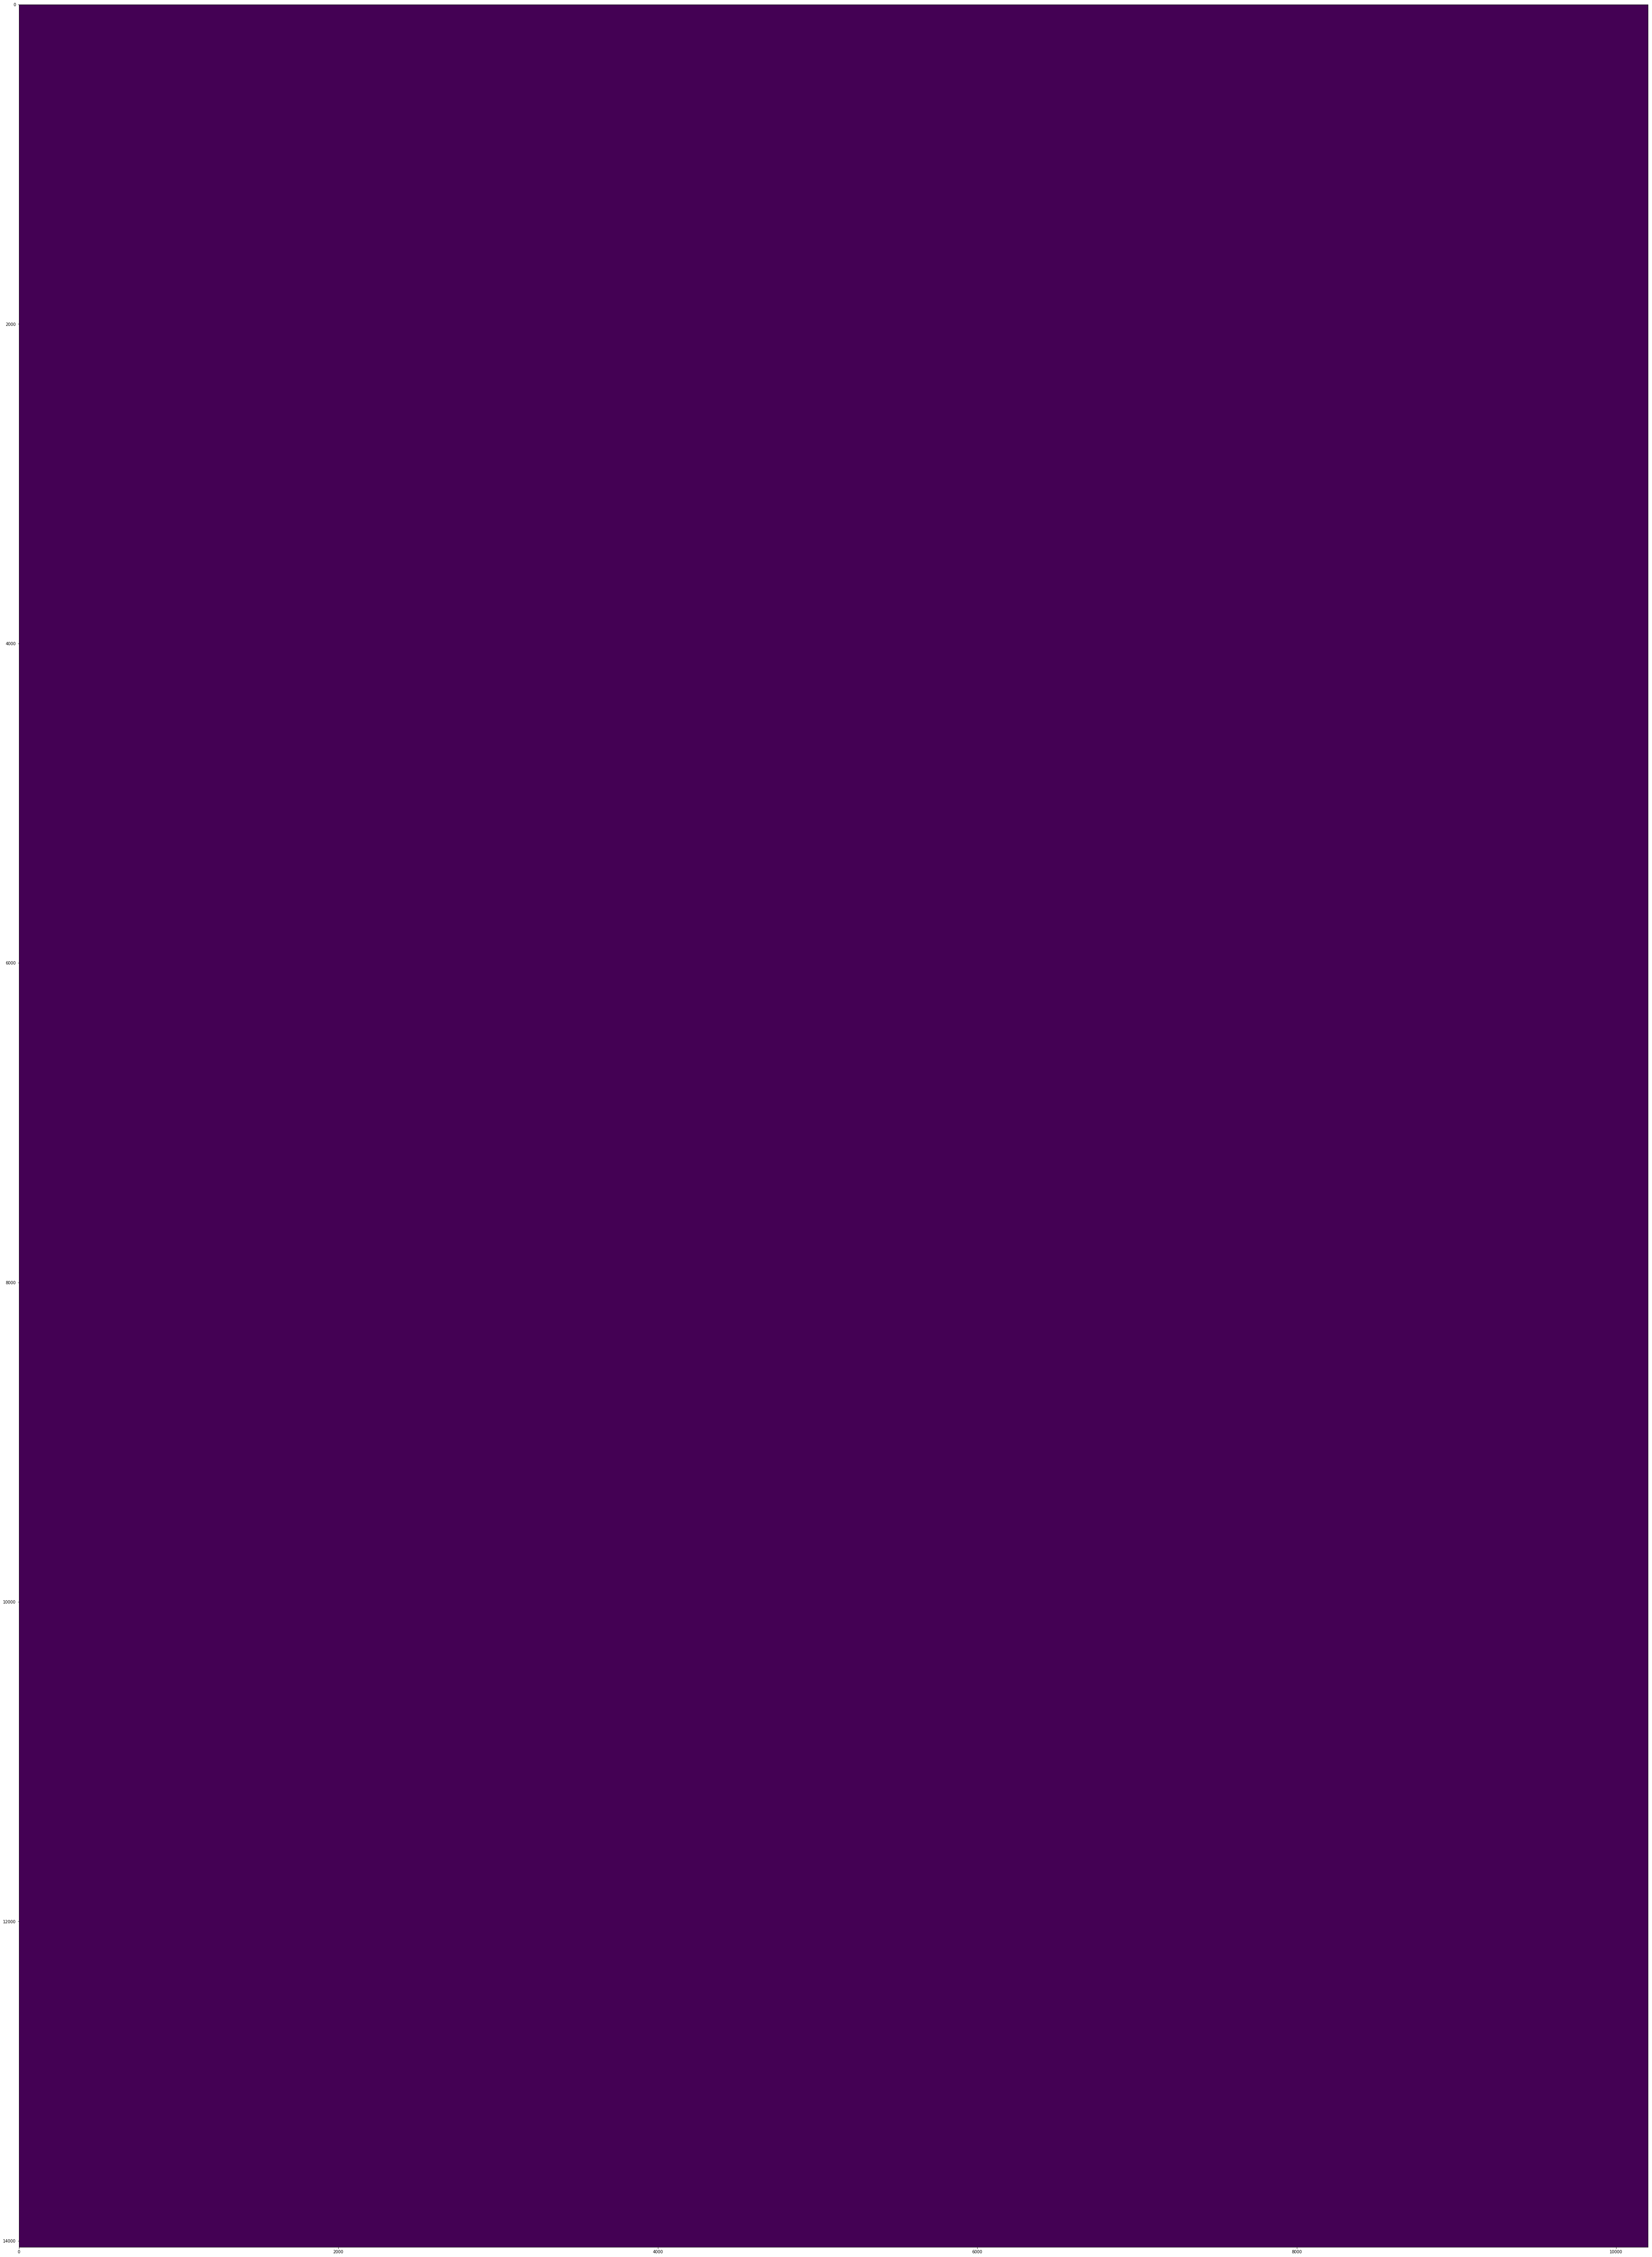

In [11]:
plt.figure(figsize=(150,100))
plt.imshow(crf_result)

In [12]:
plt.figure(figsize=(150,100))
plt.imshow(img_crf_full.astype('uint8'))
plt.imshow((pred_result*255).astype('uint8'), alpha=.6)